# CS5228-2021 (Semester 1) Final Project

In [271]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform
from datetime import datetime


from utils import *

from sklearn.metrics import mean_squared_error

### Data set Details

Data fields
- listing_id - the unique id for the listing of a used car
- title - title of the listing; free text attribute typically containing the make, model, engine type/size
- make - make/brand of the car
- model - model of the car (for the given make/brand)
- description - title of the listing; free text attribute
- manufactured - Year the car was manufactured
- original_reg_date - Original registration data; date format string
- reg_date - Registration data; date format string
- type_of_vehicle - Type of vehicle (e.g., "sports car", "luxury sedan")
- category - Category of the car; list of categories, comma-separated
- transmission - Type of transmission ("auto" or "manual")
- curb_weight - Weight in kg of the vehicle without any passenger or items
- power - Power of engine in kW
- fuel_type - Fuel type (e.g, "petrol", "diesel", "electric")
- engine_cap - Displacement of engine in cc (cubic centimeter)
- no_of_owners - Number of previous owners (>=1 since all cars are used)
- depreciation - Annual depreciation in SGD is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span
- coe - Certificate of entitlement value in SGD when first registered
- road_tax - Road tax value in SGD calculated based on the engine capacity on a per annum basis
- dereg_value - deregistration value in SGD one will get back from the government upon deregistering the vehicle for use in Singapore
- mileage - Number of kilometers driven
- omv - Open Market Value in SGD assessed by the Singapore Customs
- arf - Additional Registration Fee in SGD is a tax imposed upon registration of a vehicle
- opc_scheme - Off-peak car scheme
- lifespan - Date stated on the lifespan marks the day that the vehicle must be deregistered
- eco_category - Eco category of vehicle
- features - Noteworthy features; free text attribute
- accessories - Noteworthy accessories ; free text attribute
- indicative_price - General guide to the price in SGD of the vehicle
- price - Resale price in SGD of the car

In [272]:
train = pd.read_csv('data/train.csv', sep=',')
test = pd.read_csv('data/test.csv', sep=',')

print('The shape of train is {}'.format(train.shape))
print('The shape of test is {}'.format(test.shape))

The shape of train is (16784, 30)
The shape of test is (5000, 29)


In [273]:
#train.head()

In [274]:
#Checking for duplicates
train = train.loc[~train.duplicated()]

In [275]:
trainX = train.loc[:, train.columns != 'price']
trainY = train.loc[:, 'price']

In [276]:
from sklearn.base import BaseEstimator, TransformerMixin

class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.make_list = []
        pass
    
    def fit(self, df):
        self.make_list = df.make.unique()
        return self
        
    def transform(self, df):
        df.loc[:, 'reg_date'] = np.where(df['reg_date'].isnull(),df['original_reg_date'],df['reg_date'])
        df.loc[:, 'reg_date_year'] = pd.to_datetime(df.reg_date).dt.year
        df.loc[:, 'reg_date_month'] = (datetime.now()-pd.to_datetime(df.reg_date))/np.timedelta64(1, 'M')
        df.loc[:, 'no_of_owners'] = df['no_of_owners'].fillna(1)
        df.loc[:, 'title'] = df['title'].str.lower()
        df.loc[:, 'make'] = df.apply(
            lambda row: get_make_from_title(self.make_list, row['title']) if pd.isnull(row['make']) else row['make'],
            axis=1)
        df.loc[:, 'make_model'] = df.make + "-" + "df.model"
        return df

In [277]:
from sklearn.base import BaseEstimator, TransformerMixin

class PostProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop= ['indicative_price', 'original_reg_date', 'opc_scheme', 'lifespan', 'fuel_type', 
                  'description', 'features', 'accessories', 'listing_id', 'title', 'eco_category', 'reg_date', 
                              'road_tax', 'model', 'category', 'make']
        pass
    
    def fit(self, df):
#         self.make_list = df.make.unique()
        return self
        
    def transform(self, input_df):
        df = input_df.copy()
        df = df.drop(self.columns_to_drop, axis=1, errors='ignore')
        return df

In [278]:
from sklearn.base import BaseEstimator, TransformerMixin

class GroupMissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, col, group_cols, agg='mean'):
        self.group_mapping = {}
        self.group_cols = group_cols
        self.agg = agg
        self.col = col
    
    def fit(self, df):
        col = self.col
        if self.agg=='first':
            self.group_mapping = df[~df[col].isnull()].groupby(self.group_cols).first()[col].to_dict()
        elif self.agg=='mean':
            self.group_mapping = df[~df[col].isnull()].groupby(self.group_cols).mean()[col].to_dict()
        elif self.agg=='median':
            self.group_mapping = df[~df[col].isnull()].groupby(self.group_cols).median()[col].to_dict()
        else:
            raise Exception("Unknown Agg type")
        return self
        
    def transform(self, input_df):
        col = self.col
        df = input_df.copy()
        if col is not None and col in df.columns:
            key = tuple(self.group_cols) 
            if df[col].dtype == np.object_:
                unknown_value = 'unknown'
            else:
                if self.agg=='mean':
                    unknown_value=df[col].mean()
                else:
                    unknown_value=df[col].median()
            result = df.apply(lambda row: self.group_mapping.get(key, unknown_value) if pd.isnull(row[col]) else row[col],
            axis=1)
            df.loc[:, col] = result
            return df
        return df

In [279]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanMissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, agg='mean'):
        self.mapping = {}
        self.agg = agg
        self.cols = cols
    
    def fit(self, df):
        cols = self.cols
        for col in cols:
            self.mapping[col] = df[col].mean()
        return self
        
    def transform(self, input_df):
        cols = self.cols
        df = input_df.copy()
        for col in cols:
            df.loc[:, col] = df.fillna(self.mapping[col])
        return df

class SplitValuesToColumn(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.val_list = {}
        self.col = col
        
    
    def fit(self, df):
        categories = set()
        for values in df[self.col].unique():
            for value in values.split(','):
                if len(value.strip())>2:
                    categories.add(value.strip())

        self.val_list = categories
        return self
        
    def transform(self, input_df):
        col = self.col
        df = input_df.copy()
        df.reset_index(inplace=True, drop=True)
        df_cat=pd.DataFrame(df[col].apply(lambda x: make_category_vector(self.val_list, list(map(str.strip, x.split(','))))).tolist())
        df_cat = df_cat.add_prefix(col+'_')
        result = pd.concat([df, df_cat], axis=1)
        return result


### Data Cleaning

1) Handle Missing values in 'make' column
> The make values are extracted from the title column text values. 

2) Handle Missing values in 'reg_date' column
> Replace null values with 'original_reg_date' column values

3) Handle Missing values in 'manufactured' column
> We can find the values for similar cars and fill-in the null values. (Similar cars => model ~ make ~ type_of_vehicle)

In [280]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

ct = ColumnTransformer(
     [('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'),['type_of_vehicle', 'transmission', 'make_model']),
    
     ],remainder='passthrough')

In [281]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipe = Pipeline([
    ('pre_processing', PreProcessing()),
    ('imp_manufactured', GroupMissingValueImputer('manufactured', ['make', 'model','type_of_vehicle'], 'first')), 
    ('imp_power', GroupMissingValueImputer('power', ['type_of_vehicle'], 'mean')),
    ('imp_mileage', GroupMissingValueImputer('mileage', ['reg_date_year'], 'mean')),
    ('imp_omv', GroupMissingValueImputer('omv', ['make', 'model','manufactured'] )),
    ('imp_arf', GroupMissingValueImputer('arf', ['make', 'model','reg_date_year'])),
    ('imp_engine_cap', GroupMissingValueImputer('engine_cap', ['make', 'type_of_vehicle'], 'mean')),
    ('imp_curb_weight', GroupMissingValueImputer('curb_weight', ['make', 'type_of_vehicle'])),
#     ('imp_road_tax', GroupMissingValueImputer('road_tax', ['engine_cap'])),
    ('imp_depreciation', MeanMissingValueImputer(['depreciation', 'coe', 'dereg_value'])),
    ('add_cat', SplitValuesToColumn('category')),
    ('post_processing', PostProcessing()),
    ('normalization', ct)
])



In [282]:
X_train = pipe.fit_transform(trainX)
X_test = pipe.transform(test)
y_train=trainY

/home/akshatjhalani_y12/anaconda3/envs/nus_dm/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [263]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=72)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [264]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

/home/akshatjhalani_y12/anaconda3/envs/nus_dm/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/akshatjhalani_y12/anaconda3/envs/nus_dm/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/akshatjhalani_y12/anaconda3/envs/nus_dm/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is t

In [265]:
rfr_hpo = { 'max_depth': [40, 50, 60, 100],
 'max_features': ['sqrt'],
 'n_estimators': [100, 200, 400]}

gb_hpo = {'n_estimators':[200,400],'learning_rate':[0.01,.1],'max_depth':[40, 60, 100],'max_features': ['sqrt']}
xgb_hpo = {'n_estimators':[200,400, 600], 'max_depth':[40, 60, 100]}
                             

space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]

In [266]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

model=RandomForestRegressor
# model = GradientBoostingRegressor()
# model = Ridge()
# model = xgb.XGBRegressor
rf_random = RandomizedSearchCV(estimator=model(), param_distributions = rfr_hpo, n_iter = 20, cv = 3, verbose=3, random_state=42, n_jobs = -1)

In [267]:
rf_random.fit(X_train, y_train)

/home/akshatjhalani_y12/anaconda3/envs/nus_dm/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 12 candidates, totalling 36 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [40, 50, 60, 100],
                                        'max_features': ['sqrt'],
                                        'n_estimators': [100, 200, 400]},
                   random_state=42, verbose=3)

In [283]:
best_model=RandomForestRegressor(**rf_random.best_params_)
# best_model = xgb.XGBRegressor(n_estimators=200, 
#                              eta=0.2, gamma=1, max_depth=50, 
#                              reg_lambda=1, n_jobs=-1)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=200)

In [286]:
y_pred = best_model.predict(X_test)

In [270]:
mean_squared_error(y_test, y_pred, squared=False)

25909.104137505816

In [103]:
train[train.listing_id==959305]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
12996,959305,Rolls-Royce Cullinan 6.75A,rolls-royce,cullinan,the first ever rolls-royce suv guarantees to a...,2020.0,NaN,11-jan-2021,suv,"parf car, rare & exotic, almost new car, premi...",...,88.0,426088.0,738959.0,NaN,NaN,uncategorized,powered by a 6.75l v12 twin-turbocharged engin...,"22""alloy polished wheels, extended leather hea...",NaN,1670800.0


In [129]:
X_test.loc[:,'actual']=y_test
X_test.loc[:,'pred']=y_pred


/home/akshatjhalani_y12/anaconda3/envs/nus_dm/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/akshatjhalani_y12/anaconda3/envs/nus_dm/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [136]:
X_test[abs(X_test['actual']-X_test['pred']) > 300000]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,actual,pred
1591,959305,Rolls-Royce Cullinan 6.75A,rolls-royce,cullinan,the first ever rolls-royce suv guarantees to a...,2020.0,NaN,11-jan-2021,suv,"parf car, rare & exotic, almost new car, premi...",...,426088.0,738959.0,NaN,NaN,uncategorized,powered by a 6.75l v12 twin-turbocharged engin...,"22""alloy polished wheels, extended leather hea...",NaN,1670800.0,1330187.0
1721,985776,Lamborghini Aventador LP750-4 Superveloce,lamborghini,aventador,limited to 600 units worldwide! when you add s...,2016.0,NaN,16-jul-2019,sports car,"parf car, rare & exotic, low mileage car",...,480648.0,837167.0,NaN,NaN,uncategorized,naturally aspirated 6.5l v12 that develops 740...,"keyless engine start, multi function steering ...",NaN,1689100.0,1303534.0
2197,967117,Ferrari F512M (COE till 05/2028),ferrari,f512m,"swansong of the testarossa range, the final it...",1996.0,NaN,25-jun-1998,sports car,"coe car, rare & exotic",...,251108.0,351552.0,NaN,NaN,uncategorized,4.9 litre flat twelve engine producing 434hp a...,ferrari carbon sport bucket seats. classy tan ...,NaN,976800.0,505348.0
2249,1001205,RUF RT35S,ruf,rt35s,1 in asia. original ruf. real mileage 8329km. ...,2013.0,09-aug-2013,31-mar-2014,sports car,"imported used vehicle, parf car, rare & exotic...",...,181078.0,297941.0,NaN,NaN,uncategorized,1,ruf carbon ceramic brakes. original ruf lifter.,NaN,1097800.0,441350.0
2952,992038,Rolls-Royce Dawn Black Badge,rolls-royce,dawn,brand new black badge. only one in the market....,NaN,25-feb-2021,NaN,sports car,"imported used vehicle, coe car, rare & exotic",...,385000.0,NaN,NaN,NaN,uncategorized,powerful 6.6l v12 twin-turbo charged engine pr...,full factory options.,NaN,1848000.0,1535811.0
3285,959727,Rolls-Royce Cullinan 6.75A,rolls-royce,cullinan,elegant color combination. almost fully loaded...,2020.0,14-dec-2020,NaN,suv,"imported used vehicle, coe car, rare & exotic,...",...,405888.0,NaN,NaN,NaN,uncategorized,powered by a v12 twin-turbo engine producing 5...,"22"" polished twin spoke rims, hotspur red upho...",NaN,1851300.0,1534281.0


In [142]:
train[(~train.description.isnull()) & (train.description.str.contains('1 in asia'))]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
13300,1001205,RUF RT35S,ruf,rt35s,1 in asia. original ruf. real mileage 8329km. ...,2013.0,09-aug-2013,31-mar-2014,sports car,"imported used vehicle, parf car, rare & exotic...",...,8329.0,181078.0,297941.0,NaN,NaN,uncategorized,1,ruf carbon ceramic brakes. original ruf lifter.,NaN,1097800.0


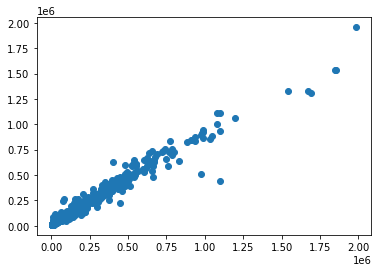

In [132]:
plt.scatter(y_test, y_pred)


<BarContainer object of 115 artists>

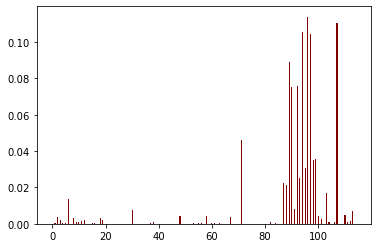

In [68]:
# plt.hist(best_model.feature_importances_)
plt.bar(list(range(len(best_model.feature_importances_))), best_model.feature_importances_, color ='maroon',
        width = 0.4)

In [287]:
y_pred.shape

(5000,)

In [ ]:
X_test = pipe.transform(test)

In [ ]:
y_pred = rf_random.predict(X_test)

In [24]:
my_submission = pd.DataFrame({'Id': list(test.index), 'Predicted': y_pred})

my_submission.to_csv('submission.csv', index=False)

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(train.listing_id, train.price)

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(train.price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=train.price)

plt.show()

In [ ]:
print(train.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

>Inference :
>
>There is a significant difference between the mean and the median of the price distribution.
>
>90% of the prices are below 200000, whereas the remaining 10% are between 200000 and 3000000.

### EDA

In [ ]:
train.price.max()

In [ ]:
train[train.price>=1520500]

In [ ]:
len(train.make.unique())

In [ ]:
train.shape

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Type Distribution Plot')
plt1 = train.type_of_vehicle.value_counts().plot(kind='bar')
plt1.set(xlabel = 'Car Type', ylabel='Frequency')

plt.subplot(1,2,2)
plt.title('Car Make Distribution Plot')
plt1 = train.make.value_counts().plot(kind='bar')
plt1.set(xlabel = 'Car Make', ylabel='Frequency')

plt.show()

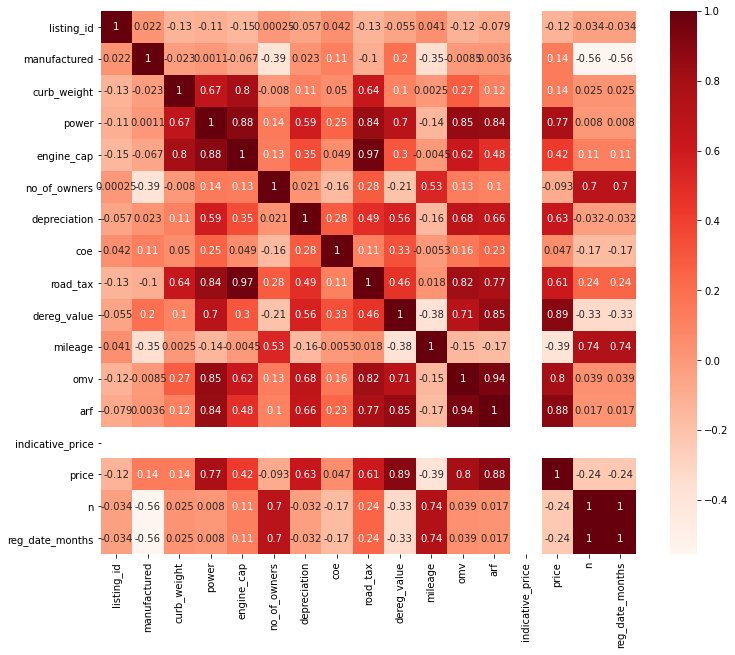

In [21]:
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Type Histogram')
sns.countplot(train.category, palette=("cubehelix"))

plt.subplot(1,2,2)
plt.title('Type vs Price')
sns.boxplot(x=train.category, y=train.price, palette=("cubehelix"))

plt.show()

In [ ]:
train.isnull().sum()[train.isnull().sum() >= 1]

### Test dataset Verification

In [40]:
test['price']=my_submission['Predicted']

In [42]:
test[test.make=='rolls-royce']

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,reg_date_year,price
310,991508,rolls-royce ghost,rolls-royce,ghost,2013 rr ghost. extended warranty under optimaw...,2012.0,04-jan-2013,16-may-2013,luxury sedan,"imported used vehicle, parf car, rare & exotic...",...,267091.0,267091.0,NaN,NaN,uncategorized,"6.6l twin turbo v12 producing 563 bhp, torque ...",full options,NaN,2013,5.271493e+05
824,1029544,rolls-royce dawn,rolls-royce,dawn,very well spec rr dawn. extremely low mileage....,2016.0,NaN,15-sep-2017,sports car,"parf car, rare & exotic, low mileage car",...,421222.0,730200.0,NaN,NaN,uncategorized,"6.6-liter, twin-turbo v-12 engine pumps out 56...","ventilated aircon seats, full luxury canadel w...",NaN,2017,1.112606e+06
1984,1020639,rolls-royce wraith,rolls-royce,wraith,lowest depreciation wraith. visit our showroom...,2016.0,NaN,13-nov-2017,sports car,"parf car, rare & exotic, low mileage car",...,338976.0,582157.0,NaN,NaN,uncategorized,powerful 6.6l v12 twin-turbo charged engine pr...,"weighted logos, rr monogram headrest, comfort/...",NaN,2017,1.029086e+06
2561,938423,rolls-royce silver cloud iii,rolls-royce,silver,pristine 1 owner unit in sg! only 5 rare units...,1963.0,07-aug-1963,03-may-2019,mid-sized sedan,"imported used vehicle, parf car, rare & exotic...",...,22074.0,22904.0,NaN,NaN,uncategorized,insane 6.2l v8 engine pushing 276 horsepower m...,"classic plate, air conditioning, leather seats...",NaN,2019,6.183615e+05
3031,992315,rolls-royce wraith black badge,rolls-royce,wraith,brand new wraith black badge - view at our sho...,NaN,20-mar-2021,20-mar-2021,sports car,"imported used vehicle, coe car, rare & exotic",...,400000.0,NaN,NaN,NaN,uncategorized,powered by a 6.6l v12 engine mated to 8-speed ...,black badge.,NaN,2021,1.684789e+06
3352,1012432,rolls-royce phantom ewb,rolls-royce,phantom,"agent unit, original 2-toned paint colour, car...",2013.0,NaN,08-jan-2014,luxury sedan,"parf car, rare & exotic, low mileage car",...,617416.0,1083350.0,NaN,NaN,uncategorized,powerful 6.7l v12 engine producing 453bhp and ...,NaN,NaN,2014,8.883272e+05
4344,991928,rolls-royce silver shadow (coe till 03/2028),rolls-royce,silver,"produced between 1965 to 1980, car comes with ...",1973.0,15-jun-1973,20-mar-2018,luxury sedan,"imported used vehicle, coe car, rare & exotic,...",...,18553.0,18553.0,NaN,NaN,uncategorized,"6.2l v8 engine 200bhp, 4 speed gearbox.","immaculate condition, interior has been reupho...",NaN,2018,7.195838e+05
4444,951365,rolls-royce dawn,rolls-royce,dawn,brand new condition! visit our showroom to vie...,2016.0,NaN,12-mar-2017,sports car,"parf car, rare & exotic, low mileage car",...,469254.0,816658.0,NaN,NaN,uncategorized,powerful 6.6l v12 twin turbo charged engine pr...,"ventilated seats, bespoke audio and more. full...",NaN,2017,1.208198e+06
4498,1030793,rolls-royce wraith,rolls-royce,wraith,8,2018.0,NaN,01-mar-2021,sports car,"parf car, rare & exotic, almost new car, low m...",...,374639.0,646351.0,NaN,NaN,uncategorized,powered by a 6.6l v12 engine mated to 8-speed ...,"rr diamond black paintwork, rr 20inch seven sp...",NaN,2021,1.388577e+06


In [34]:
train[train.make=='rolls-royce']

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
265,1025654,Rolls-Royce Ghost EWB,rolls-royce,ghost,visit our showroom to view this car.,2013.0,NaN,06-aug-2013,luxury sedan,"parf car, rare & exotic, low mileage car",...,39565.0,423356.0,423356.0,NaN,NaN,uncategorized,"6.6l twin turbo v12 producing 563 bhp, torque ...","active air suspension, sunroof, front and rear...",NaN,528000.0
548,1027235,Rolls-Royce Dawn Black Badge,rolls-royce,dawn,"3-year/100,000km warranty! the rolls-royce spi...",NaN,02-mar-2020,NaN,sports car,"imported used vehicle, coe car, rare & exotic",...,NaN,315894.0,NaN,NaN,NaN,uncategorized,"powerful 6.6l v12 engine producing 593bhp, 780...","21"" rr black badge carbon-alloy rims, multi-fu...",NaN,1529000.0
601,1023783,Rolls-Royce Dawn,rolls-royce,dawn,the dawn was released as part of the ghost/wra...,2016.0,NaN,16-sep-2016,sports car,"parf car, rare & exotic, low mileage car",...,15000.0,421688.0,731039.0,NaN,NaN,uncategorized,agent unit. powerful 6.6l v12 twin turbo charg...,"special midnight sapphire paintwork, mandarin ...",NaN,1078000.0
630,1028638,Rolls-Royce Phantom (COE till 08/2030),rolls-royce,phantom,year of the dragon special edition. beautiful ...,2011.0,NaN,30-apr-2012,luxury sedan,"coe car, rare & exotic, low mileage car",...,16800.0,503749.0,503749.0,NaN,NaN,uncategorized,view specs of the rolls-royce phantom,"chrome 21"" rims.",NaN,756800.0
1016,1022386,Rolls-Royce Ghost (COE till 07/2031),rolls-royce,ghost,price inclusive of brand new coe. luxurious ra...,2011.0,NaN,23-jul-2011,luxury sedan,"coe car, rare & exotic, low mileage car",...,70000.0,317662.0,317662.0,NaN,NaN,uncategorized,6.6l v12 twin-turbocharged engine producing 56...,"electric seats, bluetooth audio and phone, sun...",NaN,522500.0
1154,994902,Rolls-Royce Phantom,rolls-royce,phantom,electric blue with coach line. unregistered ph...,NaN,25-jan-2021,NaN,luxury sedan,"imported used vehicle, coe car, rare & exotic",...,NaN,360000.0,NaN,NaN,NaN,uncategorized,powerful 6.7l v12 engine producing 453bhp and ...,factory option.,NaN,2310000.0
1266,985507,Rolls-Royce Phantom Series II (New 10-yr COE),rolls-royce,phantom,544,2012.0,NaN,12-apr-2013,luxury sedan,"coe car, rare & exotic, low mileage car",...,36999.0,544412.0,544412.0,NaN,NaN,uncategorized,powerful 6.7l v12 engine producing 453bhp and ...,"21"" wheels, full leather interior with individ...",NaN,878900.0
2314,1027105,Rolls-Royce Ghost EWB,rolls-royce,ghost,"used imported car, very well maintained and ch...",2012.0,04-mar-2013,16-dec-2013,luxury sedan,"parf car, direct owner sale, low mileage car",...,42406.0,299250.0,510650.0,NaN,NaN,uncategorized,"lazulli blue colour, rare colour. view specs o...","active air suspension, sunroof, front and rear...",NaN,539000.0
2657,953473,Rolls-Royce Ghost EWB,rolls-royce,ghost,the 2012 rolls-royce ghost ewb with the new il...,2012.0,NaN,30-may-2013,luxury sedan,"parf car, rare & exotic, premium ad car",...,NaN,401776.0,401776.0,NaN,NaN,uncategorized,"6.6l twin turbo v12 producing 563 bhp, torque ...","active air suspension, sunroof, front and rear...",NaN,627000.0
2932,954816,Rolls-Royce Ghost Series II,rolls-royce,ghost,beautiful cream leather interior. comes with s...,2015.0,NaN,08-may-2015,luxury sedan,"parf car, rare & exotic, premium ad car, low m...",...,34000.0,366414.0,631546.0,NaN,NaN,uncategorized,6.6 l twin turbo v12 powerful yet smooth zf 8 ...,full cream leather interior with electronic me...,NaN,877800.0


In [6]:
train.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price'],
      dtype='object')

In [146]:
from datetime import datetime
train['reg_date_months'] = (datetime.now()-pd.to_datetime(train.reg_date))/np.timedelta64(1, 'M')

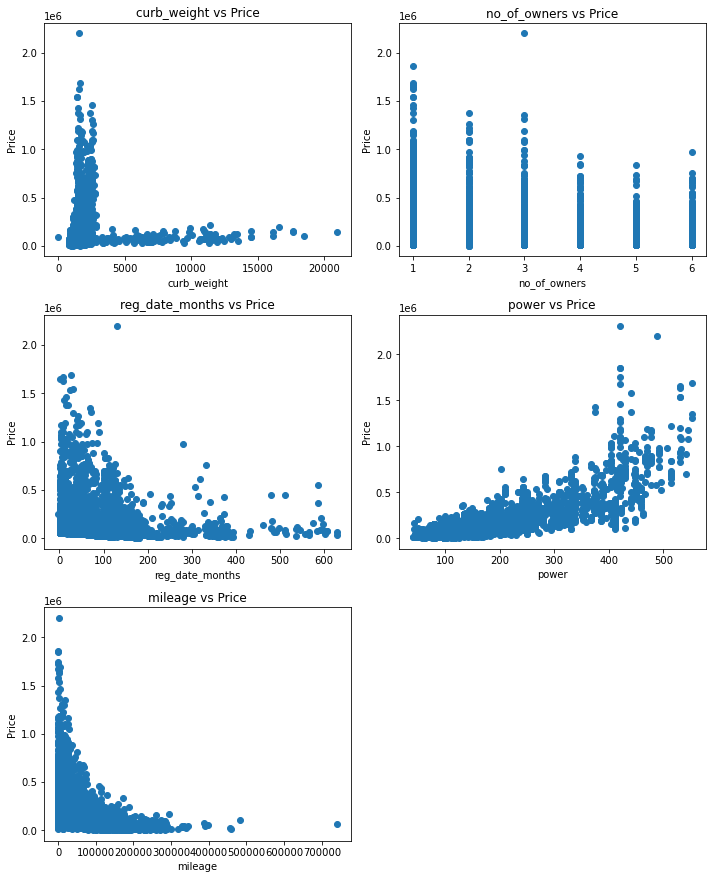

In [147]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(train[x],train['price'])
    plt.title(x+' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

plt.figure(figsize=(10,20))

scatter('curb_weight', 1)
scatter('no_of_owners', 2)
scatter('reg_date_months', 3)
scatter('power', 4)
scatter('mileage', 5)


plt.tight_layout()

>Inference :
>
>As evident, the average price is lower with increase in no_of_owners
>
>Higher power corresponds to higher price
>
>Older cars (reg_year) have lower price.

In [22]:
train.isnull().sum()[train.isnull().sum() >= 1]

make                  2160
description            345
manufactured           194
original_reg_date    16463
reg_date               201
curb_weight            579
power                 2335
fuel_type            13293
engine_cap              53
no_of_owners           176
depreciation           433
coe                    888
road_tax              2152
dereg_value           1186
mileage               3722
omv                     41
arf                    284
opc_scheme           16574
lifespan             15081
features               457
accessories           2811
indicative_price     16781
n                      201
reg_date_months        201
dtype: int64

In [144]:
print(train.mileage.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count     13059.000000
mean      72535.879164
std       50986.310608
min           1.000000
25%       32658.000000
50%       65800.000000
75%      104000.000000
85%      128000.000000
90%      141400.000000
100%     740459.000000
max      740459.000000
Name: mileage, dtype: float64


In [151]:
train[train.mileage>300000]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price,reg_date_months
86,1027556,Toyota Camry 2.0A (COE till 03/2024),toyota,camry,consignment code: b698. flexible and attractiv...,2009.0,NaN,28-apr-2009,luxury sedan,"coe car, consignment car",...,26727.0,26727.0,NaN,NaN,uncategorized,powerful 2.0l inline 4 cylinders 16 value dohc...,"dual zone ac, second row ac, electric seats, f...",NaN,26400.0,149.243819
4093,1008458,Toyota Wish 1.8A (COE till 06/2026),toyota,wish,pristine condition! all wear and tear parts do...,2006.0,NaN,11-sep-2006,mpv,coe car,...,18468.0,20315.0,NaN,NaN,uncategorized,"1.8l reliable 16 valves vvt-i dohc engine, ste...",NaN,NaN,42700.0,180.784507
4219,1021591,Honda Accord Euro R 2.0M (COE till 04/2027),honda,accord,"rare clean & neat unit with no messy mods,come...",2007.0,NaN,08-apr-2007,sports car,"coe car, premium ad car",...,30563.0,33620.0,NaN,NaN,uncategorized,"2.0l k20a dohc 16v i-vtec engine, 6 speed manu...","orig 17"" bbs sports rims,alcon bbk,tein flex z...",NaN,72500.0,173.917837
4559,989812,Nissan Cabstar,nissan,cabstar,"1 owner only, 3 month warranty, fully serviced...",2016.0,NaN,14-oct-2016,truck,-,...,24942.0,1248.0,NaN,13-oct-2036,uncategorized,view specs of the nissan cabstar,NaN,NaN,49300.0,59.681405
4636,1020391,Honda Odyssey 2.4A Absolute (COE till 05/2026),honda,odyssey,"attractive interest rate, high loan available....",2006.0,NaN,11-aug-2006,mpv,"coe car, direct owner sale",...,38612.0,42474.0,NaN,NaN,uncategorized,"2.4l powerful dohc i-vtec engine,197bhp, 5 spe...","leather seat, upgraded sport rim, pioneer dvd ...",NaN,40500.0,181.803009
5995,850013,Mitsubishi Rosa BE639,mitsubishi,rosa,"11/2009 mitsubishi rosa 20+1 seater cb plate, ...",2008.0,NaN,13-nov-2009,bus/mini bus,-,...,65982.0,3300.0,NaN,12-nov-2029,uncategorized,NaN,NaN,NaN,69100.0,142.705697
6543,1022625,Mitsubishi Lancer 1.6A GLX (COE till 04/2024),mitsubishi,lancer,consignment code : b666. flexible and attracti...,2001.0,NaN,19-jun-2001,mid-sized sedan,"coe car, consignment car",...,16982.0,23775.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,"original factory fitted leather seats, origina...",NaN,17600.0,243.537336
7070,1017967,Isuzu NPR71L (COE till 10/2024),isuzu,npr71l,high scrap value. can use as ets vehicle anyti...,2004.0,NaN,03-dec-2004,truck,coe car,...,26187.0,1310.0,NaN,02-dec-2024,uncategorized,NaN,NaN,NaN,35200.0,202.041617
7958,1023732,Nissan Atlas,nissan,atlas,consignment code b678. 1 owner only! 10 ft fla...,2014.0,NaN,18-jul-2015,truck,premium ad car,...,31806.0,1591.0,NaN,NaN,uncategorized,NaN,NaN,NaN,39600.0,74.597522
9234,1013460,Mitsubishi Lancer 1.6M GLX (COE till 08/2022),NaN,lancer,NaN,2007.0,NaN,14-aug-2007,mid-sized sedan,"coe car, premium ad car",...,10786.0,11865.0,NaN,NaN,uncategorized,view specs of the mitsubishi lancer,NaN,NaN,10800.0,169.712412
